In [11]:
# --- CELL 1: IMPORT THƯ VIỆN VÀ CÀI ĐẶT CHUNG ---

# Thư viện cơ bản cho xử lý dữ liệu và tính toán
import pandas as pd
import numpy as np

# Thư viện cho trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện Scikit-learn cho các độ đo đánh giá
from sklearn.metrics import r2_score as sklearn_r2_score 
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Thư viện Darts cho N-BEATS và các tiện ích chuỗi thời gian
try:
    from darts import TimeSeries
    from darts.models import NBEATSModel
    from darts.dataprocessing.transformers import Scaler as DartsScaler
    from darts.metrics import mape as darts_mape # Darts có hàm mape riêng xử lý zero tốt
    # from darts.utils.callbacks import EarlyStopping # Nếu muốn dùng EarlyStopping của Darts/Pytorch Lightning
    darts_available = True
except ImportError:
    darts_available = False
    print("CẢNH BÁO: Thư viện 'darts' CHƯA được cài đặt. Mô hình N-BEATS sẽ không khả dụng.")
    print("Hãy cài đặt bằng lệnh: pip install darts torch torchvision torchaudio")
    print("Lưu ý: 'torch' là một phụ thuộc quan trọng của darts cho các mô hình học sâu.")

# Cài đặt cho Matplotlib để hiển thị biểu đồ ngay trong notebook
%matplotlib inline

# Cài đặt cho Pandas để hiển thị số float (tùy chọn)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("--- Cell 1: Import Thư viện và Cài Đặt Chung Hoàn Tất ---")
if darts_available:
    print("Thư viện darts đã sẵn sàng.")
else:
    print("Vui lòng cài đặt thư viện 'darts' và 'torch' để tiếp tục với mô hình N-BEATS.")

--- Cell 1: Import Thư viện và Cài Đặt Chung Hoàn Tất ---
Thư viện darts đã sẵn sàng.


In [12]:
# --- CELL 2: ĐỌC, TIỀN XỬ LÝ VÀ THỐNG KÊ DỮ LIỆU (KHÔNG VẼ BIỂU ĐỒ EDA) ---
print("--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU (CELL 2) ---")

# --- 2.1. THU THẬP DỮ LIỆU ---
file_path = 'World GDP Dataset.csv'
try:
    df_raw_initial = pd.read_csv(file_path)
    df_raw = pd.read_csv(file_path, na_values=['0', 0.0, '']) # '' xử lý ô trống
except FileNotFoundError: print(f"Lỗi: Không tìm thấy file '{file_path}'."); raise
except Exception as e: print(f"Lỗi khi đọc file CSV: {e}"); raise
print("2.1. Đọc dữ liệu thô thành công.")

print("\n--- Thông tin DataFrame df_raw_initial (Đọc thô) ---")
if 'df_raw_initial' in locals():
    print(f"Kích thước: {df_raw_initial.shape[0]} hàng, {df_raw_initial.shape[1]} cột.")
    with pd.option_context('display.max_rows', 6, 'display.max_columns', 10, 'display.show_dimensions', False): # Tóm tắt hơn
        display(df_raw_initial) # Pandas sẽ tự tóm tắt nếu lớn
    df_raw_initial.info(memory_usage=False, verbose=False)
else: print("df_raw_initial chưa được tạo.")

# --- 2.2. XÁC ĐỊNH BIẾN MỤC TIÊU ---
print("\n--- 2.2. Xác định Biến Mục tiêu ---")
print("Biến mục tiêu là giá trị GDP. Cột GDP sẽ được hình thành sau tiền xử lý.")

# --- 2.3. TIỀN XỬ LÝ DỮ LIỆU ---
print("\n--- 2.3. Tiền xử lý dữ liệu ---")
df_raw.dropna(how='all', inplace=True)
rows_before_footer = len(df_raw)
df_raw = df_raw[~df_raw.iloc[:, 0].astype(str).str.contains("©IMF|World Economic Outlook Database|Data source:", na=False, case=False, regex=True)]
print(f"  2.3.1.1. Làm sạch: Loại bỏ {rows_before_footer - len(df_raw)} dòng footer/ghi chú.")
df_raw.rename(columns={df_raw.columns[0]: 'Country Name'}, inplace=True)
df_raw.dropna(subset=['Country Name'], inplace=True)
df_raw.reset_index(drop=True, inplace=True)
print("  2.3.1.2. Đổi tên cột quốc gia, loại bỏ dòng Country Name NaN hoàn tất.")
print(f"  df_raw sau làm sạch cơ bản: {df_raw.shape[0]} hàng, {df_raw.shape[1]} cột.")
with pd.option_context('display.max_rows', 6, 'display.max_columns', 10, 'display.show_dimensions', False):
    display(df_raw.head(3)) # Chỉ hiển thị 3 dòng đầu

print("\n  --- 2.3.2. Khám phá Dữ liệu Ban đầu (EDA trên df_raw - Chỉ thống kê) ---")
year_columns_global = df_raw.columns[1:]
df_raw_eda_stats_global = df_raw.copy()
for col in year_columns_global:
    df_raw_eda_stats_global[col] = pd.to_numeric(df_raw_eda_stats_global[col], errors='coerce')
missing_yearly_stats_global = df_raw_eda_stats_global[year_columns_global].isnull().sum()
print(f"\n    Tổng NaN theo năm (Top 3):"); display(missing_yearly_stats_global.sort_values(ascending=False).head(3).to_frame(name='Số NaN'))
if len(year_columns_global) > 0:
    sample_years_stats_global = [str(year_columns_global[0]), str(year_columns_global[len(year_columns_global)//2]), str(year_columns_global[-1])]
    existing_sample_years_global = [yr for yr in sample_years_stats_global if yr in df_raw_eda_stats_global.columns]
    if existing_sample_years_global:
        print(f"\n    Thống kê GDP cho các năm ({', '.join(existing_sample_years_global)}):"); display(df_raw_eda_stats_global[existing_sample_years_global].describe().T.head(3)) # Transpose và head
    last_year_stats_global = str(year_columns_global[-1])
    if last_year_stats_global in df_raw_eda_stats_global.columns:
        print(f"\n    Top 3 GDP cao nhất năm {last_year_stats_global}:")
        display(df_raw_eda_stats_global[['Country Name', last_year_stats_global]].sort_values(by=last_year_stats_global, ascending=False).head(3).reset_index(drop=True))

# --- 2.5. CHUYỂN ĐỔI DỮ LIỆU ---
print("\n--- 2.5. Chuyển đổi dữ liệu ---")
print("  --- 2.5.1. Chuyển đổi Wide sang Long (Melting df_raw) ---")
try:
    df_long = pd.melt(df_raw, id_vars=['Country Name'], var_name='Year', value_name='GDP')
except KeyError as e: print(f"Lỗi melt: {e}"); raise
print(f"  Chuyển đổi wide sang long thành công. df_long: {df_long.shape[0]} hàng, {df_long.shape[1]} cột.")
with pd.option_context('display.max_rows', 6, 'display.show_dimensions', False): display(df_long)

print("\n  --- 2.5.2. Chuyển đổi kiểu dữ liệu và Xử lý NaN cuối cùng cho df_long ---")
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
if df_long['GDP'].dtype == 'object': df_long['GDP'] = df_long['GDP'].astype(str).str.replace(',', '', regex=False)
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')
print("  Chuyển đổi kiểu dữ liệu Year, GDP trong df_long hoàn tất.")
rows_before_final_dropna_long = len(df_long)
df_long.dropna(subset=['Year', 'GDP'], inplace=True)
print(f"  Xử lý NaN cuối cùng trong df_long: Loại bỏ {rows_before_final_dropna_long - len(df_long)} dòng.")

print("\n  --- 2.5.3. Sắp xếp dữ liệu df_long ---")
df_long.sort_values(by=['Country Name', 'Year'], inplace=True)
df_long['Year'] = df_long['Year'].astype(int)
df_long.reset_index(drop=True, inplace=True)
print("  Sắp xếp df_long và chuyển Year về int hoàn tất.")

# --- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long cuối cùng) ---
print("\n\n--- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long CUỐI CÙNG) ---")
if 'df_long' in locals() and not df_long.empty:
    print(f"Kích thước cuối cùng: {df_long.shape[0]} hàng × {df_long.shape[1]} cột.")
    print(f"Tên cột: {df_long.columns.tolist()}"); print("\nKiểu dữ liệu:"); print(df_long.dtypes)
    print("\nGiá trị duy nhất/cột:");
    for col in df_long.columns: print(f"  - {col}: {df_long[col].nunique()}")
    print("\nKiểm tra NaN:"); print(df_long.isnull().sum())
    print("\nThống kê mô tả:"); display(df_long.describe())
    print(f"\nPhạm vi năm: {df_long['Year'].min()} - {df_long['Year'].max()}")
    print(f"Số quốc gia: {df_long['Country Name'].nunique()}")
    print(f"Số năm dữ liệu TB/quốc gia: {df_long.groupby('Country Name')['Year'].count().mean():.2f}")
    print("\nHiển thị tóm tắt df_long cuối cùng:")
    with pd.option_context('display.max_rows', 10, 'display.show_dimensions', True): # Hiển thị 10 dòng (5 đầu, 5 cuối)
        display(df_long)
else: print("df_long chưa được tạo hoặc rỗng.")
print("\n--- KẾT THÚC CHƯƠNG 2: XỬ LÝ DỮ LIỆU (CELL 2) ---")

--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU (CELL 2) ---
2.1. Đọc dữ liệu thô thành công.

--- Thông tin DataFrame df_raw_initial (Đọc thô) ---
Kích thước: 230 hàng, 45 cột.


,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,...,2019,2020,2021,2022,2023
0,Afghanistan,0.000,0.000,0.000,0.000,...,18.876,20.136,0.000,0.000,0.000
1,Albania,1.946,2.229,2.296,2.319,...,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,...,171.680,144.922,162.711,187.155,190.254
...,...,...,...,...,...,...,...,...,...,...,...
227,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
229,"©IMF, 2022",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Columns: 45 entries, GDP, current prices (Billions of U.S. dollars) to 2023
dtypes: float64(44), object(1)
--- 2.2. Xác định Biến Mục tiêu ---
Biến mục tiêu là giá trị GDP. Cột GDP sẽ được hình thành sau tiền xử lý.

--- 2.3. Tiền xử lý dữ liệu ---
  2.3.1.1. Làm sạch: Loại bỏ 1 dòng footer/ghi chú.
  2.3.1.2. Đổi tên cột quốc gia, loại bỏ dòng Country Name NaN hoàn tất.
  df_raw sau làm sạch cơ bản: 196 hàng, 45 cột.


,Country Name,1980,1981,1982,1983,...,2019,2020,2021,2022,2023
0,Afghanistan,NaN,NaN,NaN,NaN,...,18.876,20.136,NaN,NaN,NaN
1,Albania,1.946,2.229,2.296,2.319,...,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,...,171.680,144.922,162.711,187.155,190.254



  --- 2.3.2. Khám phá Dữ liệu Ban đầu (EDA trên df_raw - Chỉ thống kê) ---

    Tổng NaN theo năm (Top 3):


,Số NaN
1980,50
1982,50
1983,50



    Thống kê GDP cho các năm (1980, 2002, 2023):


,count,mean,std,min,25%,50%,75%,max
1980,146.000,76.974,275.705,0.032,1.921,6.967,40.359,2857.325
2002,193.000,180.909,878.732,0.017,2.257,9.719,70.282,10929.100
2023,190.000,556.407,2427.762,0.068,10.902,43.337,270.734,26185.210



    Top 3 GDP cao nhất năm 2023:


,Country Name,2023
0,United States,26185.210
1,"China, People's Republic of",19243.974
2,Japan,4365.976



--- 2.5. Chuyển đổi dữ liệu ---
  --- 2.5.1. Chuyển đổi Wide sang Long (Melting df_raw) ---
  Chuyển đổi wide sang long thành công. df_long: 8624 hàng, 3 cột.


,Country Name,Year,GDP
0,Afghanistan,1980,NaN
1,Albania,1980,1.946
2,Algeria,1980,42.346
...,...,...,...
8621,Yemen,2023,28.099
8622,Zambia,2023,28.798
8623,Zimbabwe,2023,37.303



  --- 2.5.2. Chuyển đổi kiểu dữ liệu và Xử lý NaN cuối cùng cho df_long ---
  Chuyển đổi kiểu dữ liệu Year, GDP trong df_long hoàn tất.
  Xử lý NaN cuối cùng trong df_long: Loại bỏ 772 dòng.

  --- 2.5.3. Sắp xếp dữ liệu df_long ---
  Sắp xếp df_long và chuyển Year về int hoàn tất.


--- 2.4. THỐNG KÊ DỮ LIỆU MẪU (df_long CUỐI CÙNG) ---
Kích thước cuối cùng: 7852 hàng × 3 cột.
Tên cột: ['Country Name', 'Year', 'GDP']

Kiểu dữ liệu:
Country Name     object
Year              int32
GDP             float64
dtype: object

Giá trị duy nhất/cột:
  - Country Name: 196
  - Year: 44
  - GDP: 7052

Kiểm tra NaN:
Country Name    0
Year            0
GDP             0
dtype: int64

Thống kê mô tả:


,Year,GDP
count,7852.000,7852.000
mean,2002.742,263.121
std,12.397,1245.565
min,1980.000,0.014
25%,1993.000,3.260
50%,2003.000,15.974
75%,2013.000,99.016
max,2023.000,26185.210



Phạm vi năm: 1980 - 2023
Số quốc gia: 196
Số năm dữ liệu TB/quốc gia: 40.06

Hiển thị tóm tắt df_long cuối cùng:


,Country Name,Year,GDP
0,Afghanistan,2002,4.367
1,Afghanistan,2003,4.553
2,Afghanistan,2004,5.146
3,Afghanistan,2005,6.167
4,Afghanistan,2006,6.925
...,...,...,...
7847,Zimbabwe,2019,22.995
7848,Zimbabwe,2020,23.181
7849,Zimbabwe,2021,32.868
7850,Zimbabwe,2022,38.280



--- KẾT THÚC CHƯƠNG 2: XỬ LÝ DỮ LIỆU (CELL 2) ---


In [13]:
# --- CELL N1.M4_1: MÔ HÌNH 4.1 (N-BEATS NHỎ) - ĐỊNH NGHĨA THAM SỐ VÀ CHUẨN BỊ TimeSeries ---

# Khởi tạo các biến sẽ được sử dụng trong các cell N-BEATS tiếp theo
ts_gdp_m4_1_darts = None
train_ts_m4_1_darts, val_ts_m4_1_darts = None, None
val_ts_orig_m4_1_darts = None 
scaler_darts_m4_1 = None
ts_gdp_scaled_m4_1_darts = None
model_nbeats_m4_1 = None
model_nbeats_final_m4_1 = None
predictions_nbeats_val_orig_m4_1 = None
forecast_nbeats_future_orig_m4_1 = None
r2_nbeats_val_m4_1, mae_nbeats_val_m4_1, rmse_nbeats_val_m4_1, mape_nbeats_val_m4_1 = np.nan, np.nan, np.nan, np.nan


if not darts_available:
    print("Bỏ qua toàn bộ khối Mô hình N-BEATS do thư viện 'darts' không khả dụng.")
else:
    # === THAM SỐ CHUNG CHO MÔ HÌNH N-BEATS NÀY ===
    MODEL_ID_M4_1 = "M4_1_NBEATS_Small"
    COUNTRY_M4_1 = 'Vietnam' 
    TEST_SIZE_RATIO_M4_1 = 0.2 # Tỷ lệ cho tập validation/test
    N_FUTURE_YEARS_M4_1 = 5    # Số năm dự báo cho tương lai

    # Siêu tham số cho N-BEATS (GIỮ RẤT NHỎ cho dữ liệu ngắn)
    INPUT_CHUNK_LENGTH_M4_1 = 10  # Số năm lịch sử nhìn lại
    OUTPUT_CHUNK_LENGTH_M4_1 = 1  # Dự báo 1 bước để dễ đánh giá và dự báo đệ quy
    
    NBEATS_NUM_STACKS = 1        
    NBEATS_NUM_BLOCKS = 1        
    NBEATS_NUM_LAYERS = 1        
    NBEATS_LAYER_WIDTHS = 32     
    NBEATS_EPOCHS = 30           
    NBEATS_BATCH_SIZE = 4        
    NBEATS_LEARNING_RATE = 1e-3  
    # ==========================================

    print(f"\n\n--- BẮT ĐẦU {MODEL_ID_M4_1} CHO {COUNTRY_M4_1.upper()} ---")
    print(f"Params: InputChunk={INPUT_CHUNK_LENGTH_M4_1}, OutputChunk={OUTPUT_CHUNK_LENGTH_M4_1}, Stacks={NBEATS_NUM_STACKS}, Blocks={NBEATS_NUM_BLOCKS}, Layers={NBEATS_NUM_LAYERS}, Width={NBEATS_LAYER_WIDTHS}, Epochs={NBEATS_EPOCHS}")

    if 'df_long' not in locals() or df_long.empty:
        print(f"Lỗi: df_long chưa được tạo hoặc rỗng. Vui lòng chạy Cell 2 trước.")
    else:
        country_data_df_m4_1 = df_long[df_long['Country Name'] == COUNTRY_M4_1].copy()
        country_data_df_m4_1.sort_values('Year', inplace=True)

        min_len_required_m4_1 = INPUT_CHUNK_LENGTH_M4_1 + OUTPUT_CHUNK_LENGTH_M4_1 + 5 
        if country_data_df_m4_1.empty or len(country_data_df_m4_1) < min_len_required_m4_1:
            print(f"Không đủ dữ liệu cho '{COUNTRY_M4_1}' ({len(country_data_df_m4_1)} điểm, cần ít nhất {min_len_required_m4_1}) để xây dựng {MODEL_ID_M4_1}.")
        else:
            print(f"Đã lọc dữ liệu cho {COUNTRY_M4_1}. Số dòng: {len(country_data_df_m4_1)}")
            try:
                country_data_df_m4_1['TimeCol'] = pd.to_datetime(country_data_df_m4_1['Year'].astype(str) + '-01-01')
                ts_gdp_m4_1_darts = TimeSeries.from_dataframe(country_data_df_m4_1, 'TimeCol', 'GDP', freq='AS-JAN')
                print("TimeSeries object của Darts đã được tạo.")
                # display(ts_gdp_m4_1_darts.pd_dataframe().head(3))
            except Exception as e:
                print(f"Lỗi nghiêm trọng khi tạo TimeSeries cho darts: {e}")
                ts_gdp_m4_1_darts = None # Đặt là None nếu lỗi



--- BẮT ĐẦU M4_1_NBEATS_Small CHO VIETNAM ---
Params: InputChunk=10, OutputChunk=1, Stacks=1, Blocks=1, Layers=1, Width=32, Epochs=30
Đã lọc dữ liệu cho Vietnam. Số dòng: 44
TimeSeries object của Darts đã được tạo.


c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\darts\timeseries.py:5248: FutureWarning: 'AS-JAN' is deprecated and will be removed in a future version, please use 'YS-JAN' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


In [14]:
# --- CELL N2.M4_1: {MODEL_ID_M4_1} - CHUẨN HÓA VÀ CHIA DỮ LIỆU ---

if 'darts_available' in locals() and darts_available and \
   'ts_gdp_m4_1_darts' in locals() and ts_gdp_m4_1_darts is not None:
    
    scaler_darts_m4_1 = DartsScaler() 
    ts_gdp_scaled_m4_1_darts = scaler_darts_m4_1.fit_transform(ts_gdp_m4_1_darts)
    print("Dữ liệu GDP đã được chuẩn hóa bằng Darts Scaler.")

    total_len_m4_1 = len(ts_gdp_scaled_m4_1_darts)
    min_val_len_needed_m4_1 = INPUT_CHUNK_LENGTH_M4_1 + OUTPUT_CHUNK_LENGTH_M4_1 # Validation cần đủ cho 1 sample
    min_train_len_needed_m4_1 = INPUT_CHUNK_LENGTH_M4_1 + OUTPUT_CHUNK_LENGTH_M4_1 # Train cũng cần đủ cho 1 sample
    
    if total_len_m4_1 < min_train_len_needed_m4_1 + min_val_len_needed_m4_1:
        print(f"CẢNH BÁO: Tổng dữ liệu ({total_len_m4_1} điểm) quá ngắn để chia train ({min_train_len_needed_m4_1} cần) và validation ({min_val_len_needed_m4_1} cần) hợp lệ.")
        train_ts_m4_1_darts, val_ts_m4_1_darts, val_ts_orig_m4_1_darts = None, None, None
    else:
        # Tính số điểm validation mong muốn, nhưng không nhỏ hơn yêu cầu tối thiểu
        desired_val_len_m4_1 = int(total_len_m4_1 * TEST_SIZE_RATIO_M4_1)
        actual_val_len_m4_1 = max(desired_val_len_m4_1, min_val_len_needed_m4_1)

        # Đảm bảo tập train còn đủ dài
        if total_len_m4_1 - actual_val_len_m4_1 < min_train_len_needed_m4_1:
            actual_val_len_m4_1 = total_len_m4_1 - min_train_len_needed_m4_1
            print(f"  Điều chỉnh kích thước tập validation thành {actual_val_len_m4_1} để đảm bảo tập train đủ dài.")
        
        if actual_val_len_m4_1 < min_val_len_needed_m4_1:
            print(f"CẢNH BÁO: Sau điều chỉnh, tập validation ({actual_val_len_m4_1}) vẫn quá ngắn (<{min_val_len_needed_m4_1}). Không thể chia.")
            train_ts_m4_1_darts, val_ts_m4_1_darts, val_ts_orig_m4_1_darts = None, None, None
        else:
            split_point_m4_1 = total_len_m4_1 - actual_val_len_m4_1
            train_ts_m4_1_darts = ts_gdp_scaled_m4_1_darts[:split_point_m4_1]
            val_ts_m4_1_darts = ts_gdp_scaled_m4_1_darts[split_point_m4_1:]
            val_ts_orig_m4_1_darts = ts_gdp_m4_1_darts[split_point_m4_1:] # Lưu bản gốc của validation set

            print(f"N-BEATS - Train (scaled): {len(train_ts_m4_1_darts)} điểm ({train_ts_m4_1_darts.start_time()} - {train_ts_m4_1_darts.end_time()})")
            print(f"N-BEATS - Validation (scaled): {len(val_ts_m4_1_darts)} điểm ({val_ts_m4_1_darts.start_time()} - {val_ts_m4_1_darts.end_time()})")
else:
    if 'darts_available' not in locals() or not darts_available: print(f"Bỏ qua {MODEL_ID_M4_1} do darts không khả dụng.")
    else: print(f"TimeSeries cho {MODEL_ID_M4_1} (ts_gdp_m4_1_darts) chưa được tạo. Không thể chuẩn hóa hoặc chia dữ liệu.")

Dữ liệu GDP đã được chuẩn hóa bằng Darts Scaler.
N-BEATS - Train (scaled): 33 điểm (1980-01-01 00:00:00 - 2012-01-01 00:00:00)
N-BEATS - Validation (scaled): 11 điểm (2013-01-01 00:00:00 - 2023-01-01 00:00:00)


In [15]:
# --- CELL N2_Tune.M4_1: {MODEL_ID_M4_1} - TÌM KIẾM SIÊU THAM SỐ VỚI OPTUNA ---

import optuna # Đảm bảo đã import ở Cell 1 hoặc import ở đây

best_nbeats_params_m4_1 = None # Khởi tạo

if 'darts_available' in locals() and darts_available and \
   'train_ts_m4_1_darts' in locals() and train_ts_m4_1_darts is not None and \
   'val_ts_m4_1_darts' in locals() and val_ts_m4_1_darts is not None:

    print(f"\n--- {MODEL_ID_M4_1}: Bắt đầu tìm kiếm siêu tham số cho N-BEATS với Optuna ---")
    print(f"Sử dụng tập train: {len(train_ts_m4_1_darts)} điểm, tập validation: {len(val_ts_m4_1_darts)} điểm.")

    # Hàm mục tiêu cho Optuna
    def objective_nbeats(trial):
        # Đề xuất các siêu tham số
        # Lưu ý: input_chunk_length và output_chunk_length thường được cố định trước dựa trên bài toán
        # Ở đây chúng ta sẽ cố định chúng theo giá trị đã chọn ở Cell N1
        # Nếu muốn Optuna tìm cả chúng, cần cẩn thận với ràng buộc độ dài dữ liệu
        
        # fixed_input_chunk = INPUT_CHUNK_LENGTH_M4_1 # Lấy từ biến toàn cục của mô hình
        # fixed_output_chunk = OUTPUT_CHUNK_LENGTH_M4_1

        # Các tham số kiến trúc có thể thử
        num_stacks = trial.suggest_int('num_stacks', 1, 3) # Số stack nhỏ
        num_blocks = trial.suggest_int('num_blocks', 1, 2) # Số block nhỏ
        num_layers = trial.suggest_int('num_layers', 1, 2) # Số lớp nhỏ
        layer_widths = trial.suggest_categorical('layer_widths', [32, 64, 128]) # Kích thước lớp ẩn
        
        # Tham số huấn luyện
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [4, 8, 16])
        n_epochs = trial.suggest_int('n_epochs', 20, 60) # Số epochs vừa phải cho tuning

        # Khởi tạo mô hình N-BEATS với các siêu tham số được đề xuất
        model_trial = NBEATSModel(
            input_chunk_length=INPUT_CHUNK_LENGTH_M4_1, # Giữ cố định từ Cell N1
            output_chunk_length=OUTPUT_CHUNK_LENGTH_M4_1, # Giữ cố định từ Cell N1
            num_stacks=num_stacks,
            num_blocks=num_blocks,
            num_layers=num_layers,
            layer_widths=layer_widths,
            n_epochs=n_epochs,
            batch_size=batch_size,
            optimizer_kwargs={'lr': learning_rate},
            random_state=42, # Giữ random_state để có thể so sánh giữa các trial
            model_name=f"{MODEL_ID_M4_1}_trial_{trial.number}", # Tên model cho mỗi trial
            force_reset=True, # Luôn huấn luyện lại từ đầu cho mỗi trial
            # log_tensorboard=False, # Tắt log để nhanh hơn khi tuning
            # save_checkpoints=False # Không cần lưu checkpoint khi tuning
        )

        try:
            # Huấn luyện mô hình trên tập train, đánh giá trên tập val
            model_trial.fit(train_ts_m4_1_darts, val_series=val_ts_m4_1_darts, verbose=False) # verbose=False để output gọn gàng

            # Dự đoán trên tập validation
            # Sử dụng model_trial.predict() vì historical_forecasts có thể phức tạp hơn cho tuning nhanh
            preds_scaled = model_trial.predict(
                n=len(val_ts_m4_1_darts), # Dự báo toàn bộ tập validation
                series=train_ts_m4_1_darts # Cung cấp lịch sử
            )

            # Biến đổi ngược (nếu scaler_darts_m4_1 đã được fit)
            if scaler_darts_m4_1:
                preds_orig = scaler_darts_m4_1.inverse_transform(preds_scaled)
                actual_orig = val_ts_orig_m4_1_darts # Sử dụng bản gốc đã lưu ở Cell N2
            else: # Nếu không có scaler (không nên xảy ra)
                preds_orig = preds_scaled
                actual_orig = val_ts_m4_1_darts # Dùng bản đã scale nếu không có bản gốc

            # Cắt actual để khớp độ dài với prediction nếu cần
            len_preds = len(preds_orig)
            actual_to_compare = actual_orig[:len_preds]
            
            # Tính toán chỉ số lỗi (ví dụ: MAE) - Optuna sẽ cố gắng tối thiểu hóa giá trị này
            # error = mean_absolute_error(actual_to_compare.pd_series(), preds_orig.pd_series())
            # Hoặc dùng RMSE
            error = np.sqrt(mean_squared_error(actual_to_compare.values().flatten(), preds_orig.values().flatten()))

            # (Tùy chọn) Xử lý Pruning: Nếu một trial quá tệ, dừng sớm
            trial.report(error, step=n_epochs) # Báo cáo lỗi ở epoch cuối
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            return error
        except optuna.exceptions.TrialPruned:
            raise # Ném lại lỗi Pruned để Optuna biết
        except Exception as e:
            print(f"Lỗi trong trial {trial.number}: {e}. Trả về giá trị lỗi lớn.")
            return float('inf') # Trả về giá trị lớn nếu có lỗi để Optuna bỏ qua trial này

    # Tạo study object và tối ưu hóa
    # `sampler`: cách Optuna chọn tham số (TPESampler là mặc định và tốt)
    # `pruner`: cách Optuna dừng sớm các trial không hứa hẹn (MedianPruner)
    study_nbeats_m4_1 = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42), # seed cho sampler
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=NBEATS_EPOCHS//3, interval_steps=1) # Pruner
    )
    
    N_OPTUNA_TRIALS = 20 # Số lần thử nghiệm (tăng lên nếu có thời gian, ví dụ 50-100)
    print(f"Bắt đầu Optuna study với {N_OPTUNA_TRIALS} trials...")
    
    try:
        study_nbeats_m4_1.optimize(objective_nbeats, n_trials=N_OPTUNA_TRIALS, timeout=600) # timeout 600 giây (10 phút)
        best_nbeats_params_m4_1 = study_nbeats_m4_1.best_params
        print(f"\n--- {MODEL_ID_M4_1}: Tìm kiếm siêu tham số hoàn tất ---")
        print("Siêu tham số N-BEATS tốt nhất tìm được:")
        print(best_nbeats_params_m4_1)
        print(f"Giá trị RMSE tốt nhất trên validation (cross-validation của Optuna): {study_nbeats_m4_1.best_value:.4f}")
    except Exception as e:
        print(f"Lỗi trong quá trình Optuna study: {e}")
        print("Sử dụng các siêu tham số N-BEATS mặc định/thủ công.")
        best_nbeats_params_m4_1 = {} # Rỗng để dùng mặc định hoặc bộ thủ công ở cell sau
else:
    if 'darts_available' not in locals() or not darts_available: print(f"Bỏ qua {MODEL_ID_M4_1} do darts không khả dụng.")
    else: print(f"Không có dữ liệu huấn luyện/validation cho {MODEL_ID_M4_1} để tìm siêu tham số.")
    best_nbeats_params_m4_1 = {} # Đảm bảo biến tồn tại

[I 2025-05-29 16:10:24,778] A new study created in memory with name: no-name-464ef3ae-87d2-434b-afc2-c65cc9e2fb97
GPU available: False, used: False



--- M4_1_NBEATS_Small: Bắt đầu tìm kiếm siêu tham số cho N-BEATS với Optuna ---
Sử dụng tập train: 33 điểm, tập validation: 11 điểm.
Bắt đầu Optuna study với 20 trials...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:25,337] Trial 0 finished with value: 242.5013677704827 and parameters: {'num_stacks': 2, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 32, 'learning_rate': 0.00013066739238053285, 'batch_size': 4, 'n_epochs': 20}. Best is trial 0 with value: 242.5013677704827.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:25,682] Trial 1 finished with value: 81.0085742666341 and parameters: {'num_stacks': 3, 'num_blocks': 2, 'num_layers': 1, 'layer_widths': 128, 'learning_rate': 0.0011207606211860567, 'batch_size': 16, 'n_epochs': 25}. Best is trial 1 with value: 81.0085742666341.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=22` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:25,906] Trial 2 finished with value: 141.3770860094979 and parameters: {'num_stacks': 1, 'num_blocks': 1, 'num_layers': 1, 'layer_widths': 32, 'learning_rate': 0.0015304852121831463, 'batch_size': 8, 'n_epochs': 22}. Best is trial 1 with value: 81.0085742666341.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=57` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:27,566] Trial 3 finished with value: 26.20262286496169 and parameters: {'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 128, 'learning_rate': 0.0007591104805282694, 'batch_size': 8, 'n_epochs': 57}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=44` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:27,967] Trial 4 finished with value: 142.13966180921295 and parameters: {'num_stacks': 1, 'num_blocks': 2, 'num_layers': 1, 'layer_widths': 64, 'learning_rate': 0.00869299151113955, 'batch_size': 8, 'n_epochs': 44}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=42` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:28,716] Trial 5 finished with value: 513.01240006374 and parameters: {'num_stacks': 3, 'num_blocks': 1, 'num_layers': 1, 'layer_widths': 128, 'learning_rate': 0.00034889766548903674, 'batch_size': 4, 'n_epochs': 42}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=51` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:29,463] Trial 6 finished with value: 245.3776539014631 and parameters: {'num_stacks': 1, 'num_blocks': 2, 'num_layers': 1, 'layer_widths': 32, 'learning_rate': 0.00010257563974185662, 'batch_size': 4, 'n_epochs': 51}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=46` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:29,739] Trial 7 finished with value: 282.86181291321935 and parameters: {'num_stacks': 1, 'num_blocks': 1, 'num_layers': 1, 'layer_widths': 32, 'learning_rate': 0.00013400367243354819, 'batch_size': 16, 'n_epochs': 46}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=21` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:30,016] Trial 8 finished with value: 72.53113916368255 and parameters: {'num_stacks': 3, 'num_blocks': 1, 'num_layers': 1, 'layer_widths': 64, 'learning_rate': 0.003482846706526885, 'batch_size': 8, 'n_epochs': 21}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=23` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:30,282] Trial 9 finished with value: 242.23593516623342 and parameters: {'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'layer_widths': 128, 'learning_rate': 0.00031519872951938895, 'batch_size': 8, 'n_epochs': 23}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=59` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:31,494] Trial 10 finished with value: 90.92199762117266 and parameters: {'num_stacks': 2, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 128, 'learning_rate': 0.00046050571989597746, 'batch_size': 8, 'n_epochs': 59}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:32,020] Trial 11 finished with value: 149.07258972509968 and parameters: {'num_stacks': 3, 'num_blocks': 1, 'num_layers': 2, 'layer_widths': 64, 'learning_rate': 0.003559891344492109, 'batch_size': 8, 'n_epochs': 32}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=34` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:32,575] Trial 12 finished with value: 104.77692565998011 and parameters: {'num_stacks': 3, 'num_blocks': 1, 'num_layers': 2, 'layer_widths': 64, 'learning_rate': 0.002510716233290128, 'batch_size': 8, 'n_epochs': 34}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=60` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:33,601] Trial 13 finished with value: 145.25610279848584 and parameters: {'num_stacks': 2, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 64, 'learning_rate': 0.005964294576013591, 'batch_size': 8, 'n_epochs': 60}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=52` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:34,189] Trial 14 finished with value: 470.01169055167713 and parameters: {'num_stacks': 3, 'num_blocks': 1, 'num_layers': 1, 'layer_widths': 128, 'learning_rate': 0.0006398190122786779, 'batch_size': 8, 'n_epochs': 52}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=34` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:34,772] Trial 15 finished with value: 78.61885768467155 and parameters: {'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 64, 'learning_rate': 0.0019090601968132807, 'batch_size': 16, 'n_epochs': 34}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=28` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:35,315] Trial 16 finished with value: 131.15137831341016 and parameters: {'num_stacks': 2, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 64, 'learning_rate': 0.0037433095612438615, 'batch_size': 8, 'n_epochs': 28}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=39` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:35,755] Trial 17 finished with value: 389.6088078413792 and parameters: {'num_stacks': 3, 'num_blocks': 1, 'num_layers': 1, 'layer_widths': 128, 'learning_rate': 0.0007954937078391092, 'batch_size': 8, 'n_epochs': 39}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=53` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:36,161] Trial 18 finished with value: 192.22862750791532 and parameters: {'num_stacks': 2, 'num_blocks': 1, 'num_layers': 1, 'layer_widths': 64, 'learning_rate': 0.0011446849853836913, 'batch_size': 16, 'n_epochs': 53}. Best is trial 3 with value: 26.20262286496169.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=37` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-29 16:10:37,980] Trial 19 finished with value: 55.12744657139849 and parameters: {'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 128, 'learning_rate': 0.00023052589054844516, 'batch_size': 4, 'n_epochs': 37}. Best is trial 3 with value: 26.20262286496169.



--- M4_1_NBEATS_Small: Tìm kiếm siêu tham số hoàn tất ---
Siêu tham số N-BEATS tốt nhất tìm được:
{'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 128, 'learning_rate': 0.0007591104805282694, 'batch_size': 8, 'n_epochs': 57}
Giá trị RMSE tốt nhất trên validation (cross-validation của Optuna): 26.2026


In [16]:
# --- CELL N3.M4_1: {MODEL_ID_M4_1} - KHỞI TẠO VÀ HUẤN LUYỆN MÔ HÌNH (SỬ DỤNG BEST PARAMS) ---

model_nbeats_m4_1 = None 

if 'darts_available' in locals() and darts_available and \
   'train_ts_m4_1_darts' in locals() and train_ts_m4_1_darts is not None and \
   'val_ts_m4_1_darts' in locals() and val_ts_m4_1_darts is not None and \
   'best_nbeats_params_m4_1' in locals() and \
   len(train_ts_m4_1_darts) >= INPUT_CHUNK_LENGTH_M4_1 + OUTPUT_CHUNK_LENGTH_M4_1 -1 and \
   len(val_ts_m4_1_darts) >= INPUT_CHUNK_LENGTH_M4_1 + OUTPUT_CHUNK_LENGTH_M4_1 -1 :

    # Sử dụng siêu tham số tốt nhất từ Optuna nếu có, nếu không dùng bộ thủ công/mặc định
    current_nbeats_params = {
        'input_chunk_length': INPUT_CHUNK_LENGTH_M4_1,
        'output_chunk_length': OUTPUT_CHUNK_LENGTH_M4_1,
        'num_stacks': NBEATS_NUM_STACKS,
        'num_blocks': NBEATS_NUM_BLOCKS,
        'num_layers': NBEATS_NUM_LAYERS,
        'layer_widths': NBEATS_LAYER_WIDTHS,
        'n_epochs': NBEATS_EPOCHS, # Có thể dùng best_nbeats_params_m4_1.get('n_epochs', NBEATS_EPOCHS)
        'batch_size': NBEATS_BATCH_SIZE, # Tương tự
        'optimizer_kwargs': {'lr': NBEATS_LEARNING_RATE}, # Tương tự
        'random_state': 42,
        'model_name': MODEL_ID_M4_1,
        'force_reset': True,
    }

    if best_nbeats_params_m4_1 and isinstance(best_nbeats_params_m4_1, dict):
        print(f"\nSử dụng siêu tham số N-BEATS tốt nhất từ Optuna: {best_nbeats_params_m4_1}")
        # Cập nhật các tham số có trong best_nbeats_params_m4_1
        # Lưu ý: Optuna có thể không tìm 'n_epochs', 'batch_size', 'learning_rate' nếu bạn không đưa vào suggest
        # Hoặc bạn có thể lấy chúng từ best_nbeats_params_m4_1 nếu đã suggest
        current_nbeats_params['num_stacks'] = best_nbeats_params_m4_1.get('num_stacks', NBEATS_NUM_STACKS)
        current_nbeats_params['num_blocks'] = best_nbeats_params_m4_1.get('num_blocks', NBEATS_NUM_BLOCKS)
        current_nbeats_params['num_layers'] = best_nbeats_params_m4_1.get('num_layers', NBEATS_NUM_LAYERS)
        current_nbeats_params['layer_widths'] = best_nbeats_params_m4_1.get('layer_widths', NBEATS_LAYER_WIDTHS)
        current_nbeats_params['n_epochs'] = best_nbeats_params_m4_1.get('n_epochs', NBEATS_EPOCHS) # Lấy từ best_params nếu có
        current_nbeats_params['batch_size'] = best_nbeats_params_m4_1.get('batch_size', NBEATS_BATCH_SIZE)
        current_nbeats_params['optimizer_kwargs'] = {'lr': best_nbeats_params_m4_1.get('learning_rate', NBEATS_LEARNING_RATE)}

    else:
        print("\nKhông tìm thấy siêu tham số từ Optuna hoặc có lỗi, sử dụng các giá trị thủ công/mặc định đã định nghĩa.")
    
    model_nbeats_m4_1 = NBEATSModel(**current_nbeats_params)
    
    print(f"\n--- {MODEL_ID_M4_1}: Bắt đầu huấn luyện N-BEATS với tham số: ---")
    for key, value in current_nbeats_params.items():
        if key not in ['input_chunk_length', 'output_chunk_length', 'random_state', 'model_name', 'force_reset']: # Bỏ qua các tham số không phải siêu tham số chính
             print(f"  {key}: {value}")

    try:
        model_nbeats_m4_1.fit(train_ts_m4_1_darts, val_series=val_ts_m4_1_darts, verbose=True)
        print("Huấn luyện N-BEATS hoàn tất.")
    except Exception as e:
        print(f"Lỗi trong quá trình huấn luyện N-BEATS: {e}")
        model_nbeats_m4_1 = None 
else:
    if 'darts_available' not in locals() or not darts_available: print(f"Bỏ qua {MODEL_ID_M4_1} do darts không khả dụng.")
    else: print(f"Không đủ dữ liệu huấn luyện hoặc validation cho {MODEL_ID_M4_1} hoặc các biến chưa được tạo.")
    if 'model_nbeats_m4_1' in locals() and model_nbeats_m4_1 is None: pass
    elif 'model_nbeats_m4_1' in locals() : del model_nbeats_m4_1

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 115 K  | train
-------------------------------------------------------------
114 K     Trainable params
705       Non-trainable params
115 K     Total params
0.463     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode



Sử dụng siêu tham số N-BEATS tốt nhất từ Optuna: {'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 128, 'learning_rate': 0.0007591104805282694, 'batch_size': 8, 'n_epochs': 57}

--- M4_1_NBEATS_Small: Bắt đầu huấn luyện N-BEATS với tham số: ---
  num_stacks: 3
  num_blocks: 2
  num_layers: 2
  layer_widths: 128
  n_epochs: 57
  batch_size: 8
  optimizer_kwargs: {'lr': 0.0007591104805282694}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PC GAME\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=57` reached.


Huấn luyện N-BEATS hoàn tất.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- M4_1_NBEATS_Small: Đánh giá trên tập Validation ---


Predicting: |          | 0/? [00:00<?, ?it/s]


--- M4_1_NBEATS_Small: Chỉ số đánh giá trên Validation (thang đo gốc, 11 điểm) ---
R-squared (Val): 0.8856
MAE (Val): 23.45
RMSE (Val): 26.20
MAPE (Val): 7.71% (Tính trên 11 điểm)


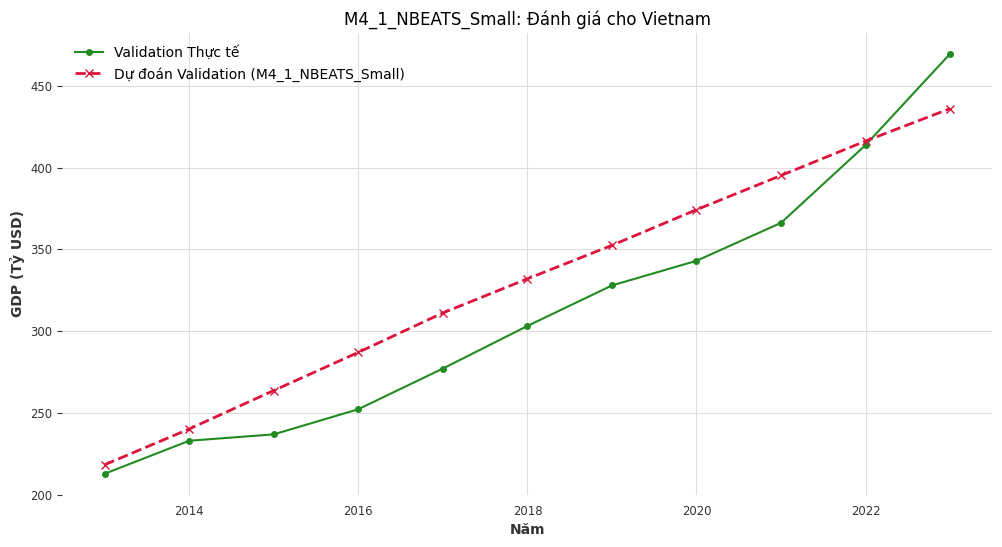

In [17]:
# --- CELL N4.M4_1: {MODEL_ID_M4_1} - ĐÁNH GIÁ TRÊN TẬP VALIDATION ---

r2_nbeats_val_m4_1, mae_nbeats_val_m4_1, rmse_nbeats_val_m4_1, mape_nbeats_val_m4_1 = np.nan, np.nan, np.nan, np.nan
predictions_nbeats_val_orig_m4_1 = None

if 'darts_available' in locals() and darts_available and \
   'model_nbeats_m4_1' in locals() and model_nbeats_m4_1 is not None and \
   'val_ts_orig_m4_1_darts' in locals() and val_ts_orig_m4_1_darts is not None and \
   'scaler_darts_m4_1' in locals() and scaler_darts_m4_1 is not None and \
   'train_ts_m4_1_darts' in locals() and train_ts_m4_1_darts is not None and \
   len(val_ts_orig_m4_1_darts) >= OUTPUT_CHUNK_LENGTH_M4_1:

    print(f"\n--- {MODEL_ID_M4_1}: Đánh giá trên tập Validation ---")
    try:
        n_pred_val_m4_1 = len(val_ts_orig_m4_1_darts)
        
        predictions_nbeats_val_scaled_m4_1 = model_nbeats_m4_1.predict(
            n=n_pred_val_m4_1, 
            series=train_ts_m4_1_darts 
        )
        
        predictions_nbeats_val_orig_m4_1 = scaler_darts_m4_1.inverse_transform(predictions_nbeats_val_scaled_m4_1)
        actual_val_orig_m4_1 = val_ts_orig_m4_1_darts 

        len_preds_val = len(predictions_nbeats_val_orig_m4_1)
        actual_to_compare_val_m4_1 = actual_val_orig_m4_1[:len_preds_val]

        actual_np_val = actual_to_compare_val_m4_1.values().flatten()
        pred_np_val = predictions_nbeats_val_orig_m4_1.values().flatten()

        print(f"\n--- {MODEL_ID_M4_1}: Chỉ số đánh giá trên Validation (thang đo gốc, {len_preds_val} điểm) ---")
        r2_nbeats_val_m4_1 = sklearn_r2_score(actual_np_val, pred_np_val)
        mae_nbeats_val_m4_1 = mean_absolute_error(actual_np_val, pred_np_val)
        rmse_nbeats_val_m4_1 = np.sqrt(mean_squared_error(actual_np_val, pred_np_val))
        
        y_true_m_val = actual_np_val.copy(); y_pred_m_val = pred_np_val.copy()
        zero_mask_val = (np.abs(y_true_m_val) < 1e-9)
        y_true_f_val = y_true_m_val[~zero_mask_val]; y_pred_f_val = y_pred_m_val[~zero_mask_val]
        if len(y_true_f_val) > 0: mape_nbeats_val_m4_1 = np.mean(np.abs((y_true_f_val - y_pred_f_val) / y_true_f_val)) * 100
        else: mape_nbeats_val_m4_1 = np.nan

        print(f"R-squared (Val): {r2_nbeats_val_m4_1:.4f}")
        print(f"MAE (Val): {mae_nbeats_val_m4_1:.2f}")
        print(f"RMSE (Val): {rmse_nbeats_val_m4_1:.2f}")
        if not np.isnan(mape_nbeats_val_m4_1): print(f"MAPE (Val): {mape_nbeats_val_m4_1:.2f}% (Tính trên {len(y_true_f_val)} điểm)")
        else: print("MAPE (Val): Không thể tính.")

        plt.figure(figsize=(12,6))
        if 'train_ts_orig_m4_1_darts' in locals() and train_ts_orig_m4_1_darts is not None:
            train_ts_orig_m4_1_darts.plot(label='Huấn luyện Thực tế', lw=1.5, color='royalblue', marker='.')
        actual_to_compare_val_m4_1.plot(label='Validation Thực tế', lw=1.5, color='forestgreen', marker='o', markersize=4)
        predictions_nbeats_val_orig_m4_1.plot(label=f'Dự đoán Validation ({MODEL_ID_M4_1})', lw=2, linestyle='--', color='crimson', marker='x', markersize=6)
        plt.title(f'{MODEL_ID_M4_1}: Đánh giá cho {COUNTRY_M4_1}')
        plt.xlabel('Năm'); plt.ylabel('GDP (Tỷ USD)'); plt.legend(); plt.grid(True); plt.show()
    except Exception as e:
        print(f"Lỗi trong quá trình đánh giá N-BEATS: {e}")
        import traceback; traceback.print_exc()
else:
    if 'darts_available' not in locals() or not darts_available: print(f"Bỏ qua {MODEL_ID_M4_1} do darts không khả dụng.")
    else: print(f"Mô hình N-BEATS ({MODEL_ID_M4_1}) chưa được huấn luyện hoặc dữ liệu validation không sẵn sàng.")